In [1]:
# LST Modelling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
#Data

In [18]:
df = pd.read_csv(r"C:\Users\hpvic\OneDrive\Desktop\LST.csv")

In [19]:
df.head()

,Year,Month,Methane,NDBI,NDVI,Humidity,Waste,WindSpeed,LST
0,2000,2,27.248944,0.324278,0.539731,0.007,5088.43062,2.301,29.02334
1,2000,3,27.348757,0.259522,0.598000,0.009,5107.06956,2.356,32.52400
2,2000,4,27.448570,0.203319,0.553186,0.014,5125.70850,3.389,30.71300
3,2000,5,27.481841,0.329682,0.497285,0.018,5131.92148,2.680,29.20666
4,2000,6,27.581654,0.204024,0.485806,0.022,5150.56042,2.537,28.03500


In [20]:
df.describe()

,Year,Month,Methane,NDBI,NDVI,Humidity,Waste,WindSpeed,LST
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,2011.541176,6.388235,331.239444,0.278843,0.452698,0.014157,8633.080482,2.601761,28.406846
std,6.748379,3.592734,193.706482,0.073855,0.115254,0.005313,3588.164875,0.681197,3.154759
min,2000.000000,1.000000,27.248944,0.029709,0.167082,0.005000,5088.430620,1.362000,21.386000
25%,2006.000000,3.000000,180.161851,0.233793,0.369612,0.009000,5837.222370,2.134500,26.514160
50%,2012.000000,6.000000,311.852449,0.282381,0.459055,0.015000,6535.460680,2.489000,28.638000
75%,2017.000000,10.000000,468.693844,0.332324,0.532829,0.019000,12157.851800,2.944500,30.739970
max,2023.000000,12.000000,743.104283,0.446012,0.731526,0.023000,16149.358640,5.114000,35.294440


In [21]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

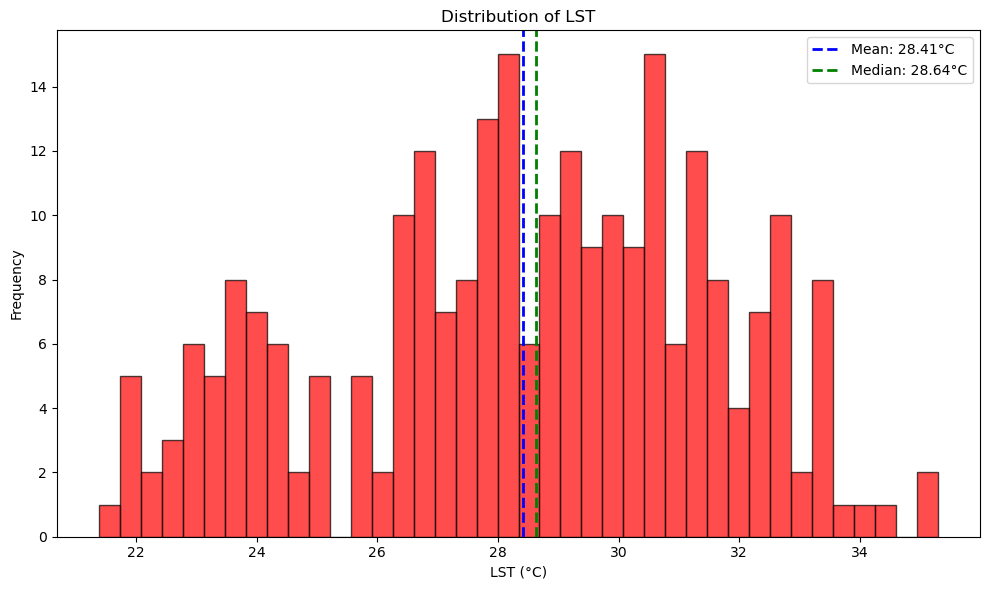

In [26]:
# LST distribution
plt.figure(figsize=(10, 6))
plt.hist(df['LST'], bins=40, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('LST (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of LST')
plt.axvline(df['LST'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {df["LST"].mean():.2f}°C')
plt.axvline(df['LST'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["LST"].median():.2f}°C')
plt.legend()
plt.tight_layout()
plt.savefig("lst_distribution.png", dpi=300, bbox_inches="tight")

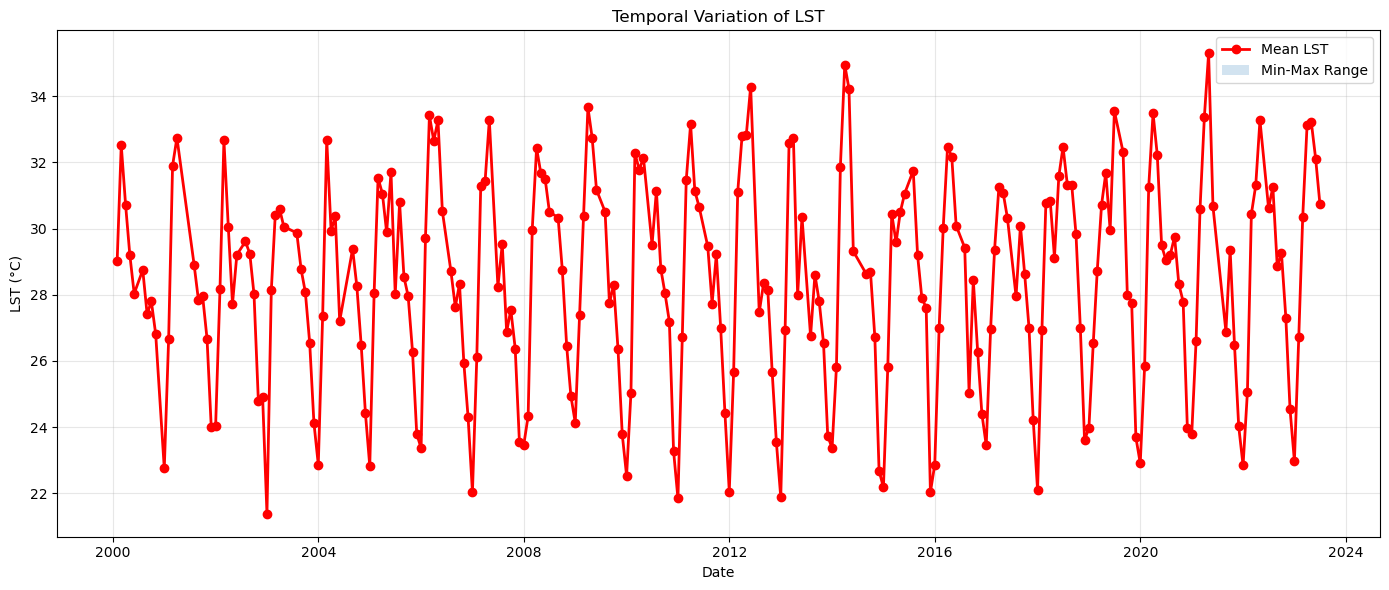

In [27]:
plt.figure(figsize=(14, 6))
monthly_lst = df.groupby('Date')['LST'].agg(['mean', 'min', 'max'])
plt.plot(monthly_lst.index, monthly_lst['mean'], marker='o', linewidth=2, color='red', label='Mean LST')
plt.fill_between(monthly_lst.index, monthly_lst['min'], monthly_lst['max'], alpha=0.2, label='Min-Max Range')
plt.xlabel('Date')
plt.ylabel('LST (°C)')
plt.title('Temporal Variation of LST')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("lst_temporal_variation.png", dpi=300, bbox_inches="tight")


In [28]:
#Correlation

In [29]:
correlation_cols = ['Methane', 'NDBI', 'NDVI', 'Humidity', 'Waste', 'WindSpeed', 'LST']
correlation_matrix = df[correlation_cols].corr()

In [30]:
LSTorr = correlation_matrix['LST'].sort_values(ascending=False)
print(LSTorr)

LST          1.000000
Humidity     0.570085
WindSpeed    0.487210
NDVI         0.436602
Waste        0.080044
Methane      0.077230
NDBI        -0.127662
Name: LST, dtype: float64


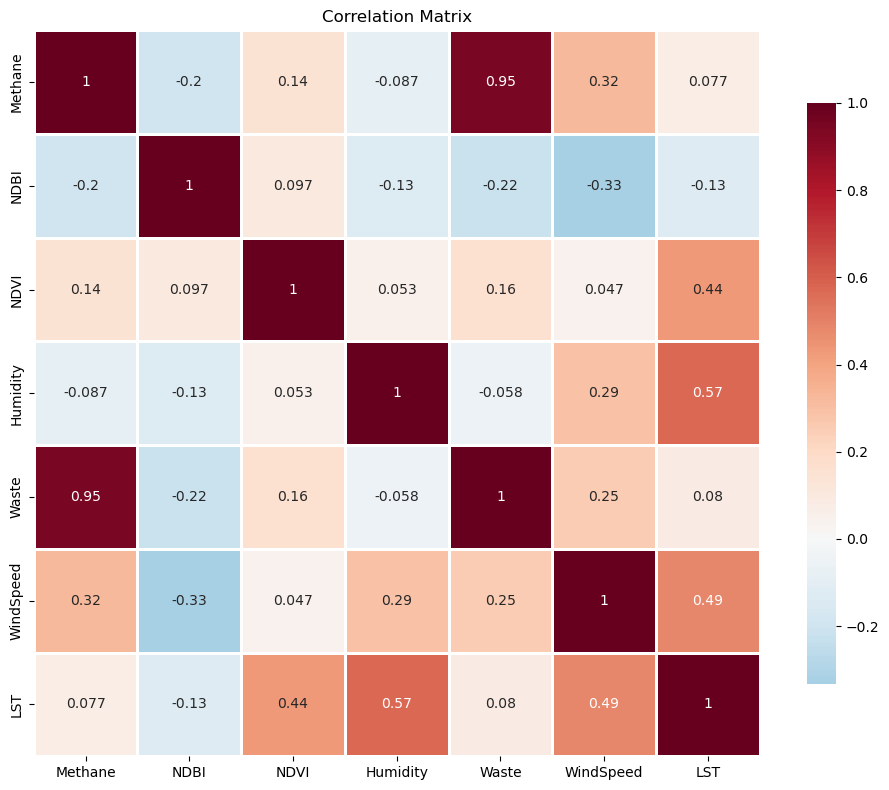

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")

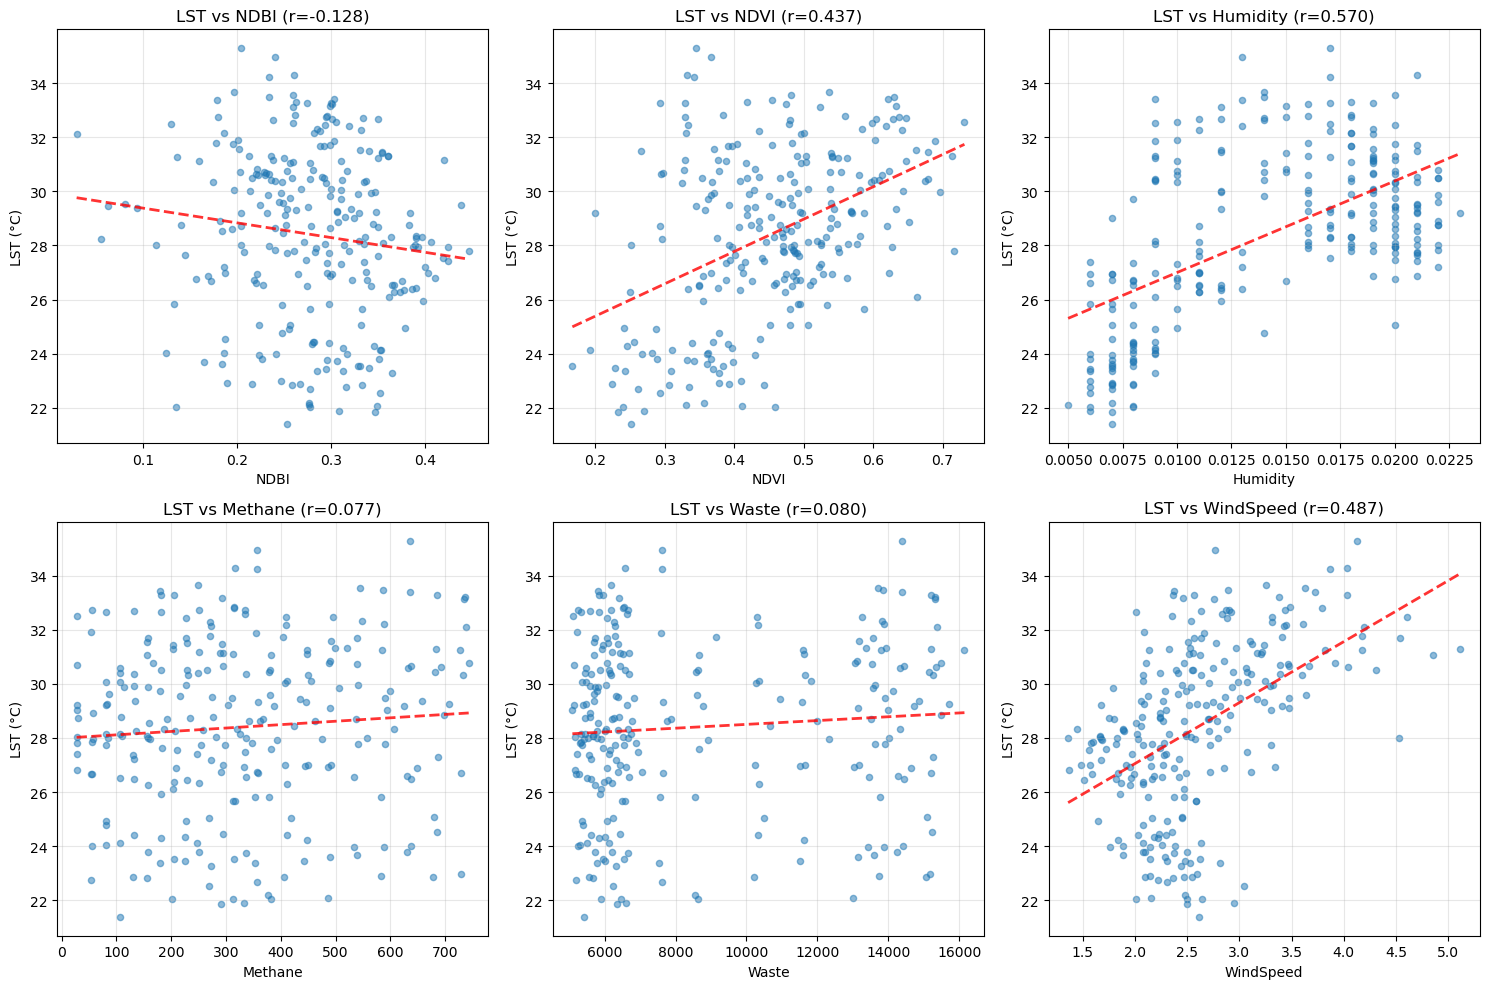

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
variables = ['NDBI', 'NDVI', 'Humidity', 'Methane', 'Waste', 'WindSpeed']

for idx, var in enumerate(variables):
    ax = axes[idx // 3, idx % 3]
    ax.scatter(df[var], df['LST'], alpha=0.5, s=20)
    ax.set_xlabel(var)
    ax.set_ylabel('LST (°C)')
    ax.set_title(f'LST vs {var} (r={correlation_matrix.loc["LST", var]:.3f})')
    # Add trend line
    z = np.polyfit(df[var], df['LST'], 1)
    p = np.poly1d(z)
    ax.plot(df[var].sort_values(), p(df[var].sort_values()), "r--", alpha=0.8, linewidth=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("lst_Vs_other.png", dpi=300, bbox_inches="tight")

In [33]:
#Feature engineering

In [34]:
df['LST_NDVI_interaction'] = df['LST'] * df['NDVI']
df['urbanization_index'] = df['NDBI'] - df['NDVI']
df['heat_humidity'] = df['LST'] * df['Humidity']
df['NDBI_squared'] = df['NDBI'] ** 2
df['waste_per_humidity'] = df['Waste'] / (df['Humidity'] + 0.01)

In [35]:
feature_cols = ['Methane', 'NDBI', 'NDVI', 'Humidity', 'Waste', 'WindSpeed', 
                'urbanization_index', 'NDBI_squared', 'waste_per_humidity']
X = df[feature_cols]
y = df['LST']

print(f"\nFeatures used: {feature_cols}")
print(f"Target: LST")
print(f"Total samples: {len(X)}")



Features used: ['Methane', 'NDBI', 'NDVI', 'Humidity', 'Waste', 'WindSpeed', 'urbanization_index', 'NDBI_squared', 'waste_per_humidity']
Target: LST
Total samples: 255


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 204
Testing samples: 51


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
results = {}

In [39]:
#Linear Regression

In [40]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
results['Linear Regression'] = {
    'model': lr_model,
    'predictions': y_pred_lr,
    'r2': r2_score(y_test, y_pred_lr),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'mae': mean_absolute_error(y_test, y_pred_lr)
}

In [41]:
#Ridge Regression

In [42]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
results['Ridge Regression'] = {
    'model': ridge_model,
    'predictions': y_pred_ridge,
    'r2': r2_score(y_test, y_pred_ridge),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'mae': mean_absolute_error(y_test, y_pred_ridge)
}

In [43]:
#Random Forest

In [44]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
results['Random Forest'] = {
    'model': rf_model,
    'predictions': y_pred_rf,
    'r2': r2_score(y_test, y_pred_rf),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'mae': mean_absolute_error(y_test, y_pred_rf)
}

In [45]:
#Gradient Boost

In [46]:
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
results['Gradient Boosting'] = {
    'model': gb_model,
    'predictions': y_pred_gb,
    'r2': r2_score(y_test, y_pred_gb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    'mae': mean_absolute_error(y_test, y_pred_gb)
}

In [47]:
#Results

In [48]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"{'Model':<20} {'R²':<10} {'RMSE':<10} {'MAE':<10}")
print("-"*60)
for model_name, metrics in results.items():
    print(f"{model_name:<20} {metrics['r2']:<10.4f} {metrics['rmse']:<10.4f} {metrics['mae']:<10.4f}")


MODEL COMPARISON
Model                R²         RMSE       MAE       
------------------------------------------------------------
Linear Regression    0.5248     1.9419     1.4693    
Ridge Regression     0.5233     1.9450     1.4688    
Random Forest        0.7151     1.5036     1.0930    
Gradient Boosting    0.5913     1.8010     1.3495    


In [49]:
best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
best_model = results[best_model_name]
print(f"\nBest Model: {best_model_name} (R² = {best_model['r2']:.4f})")


Best Model: Random Forest (R² = 0.7151)


In [50]:
#Feature Importance


FEATURE IMPORTANCE (Random Forest)
           feature  importance
          Humidity    0.552984
         WindSpeed    0.182484
              NDVI    0.109663
urbanization_index    0.055208
waste_per_humidity    0.024756
              NDBI    0.021619
      NDBI_squared    0.020710
             Waste    0.016778
           Methane    0.015799


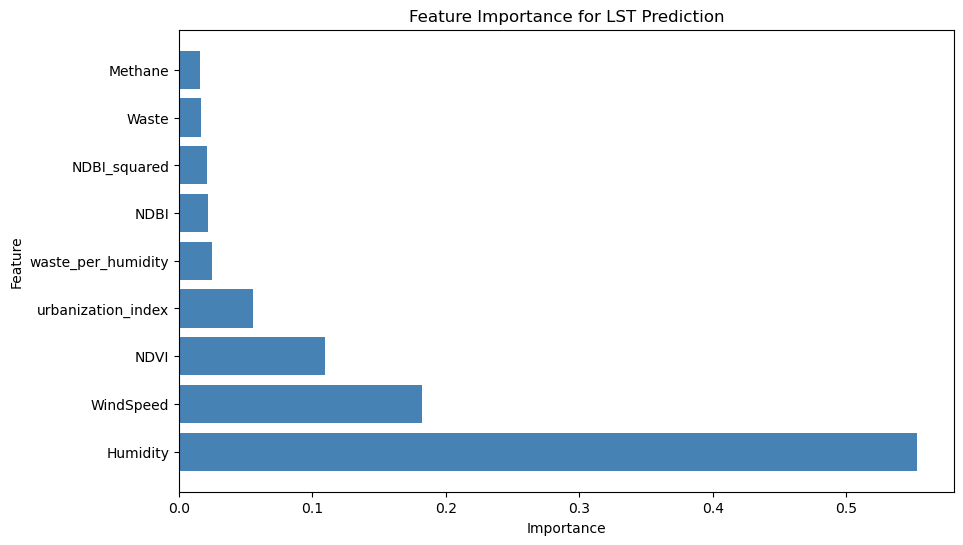

In [52]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)
print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for LST Prediction')
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")

In [53]:
#Prediction vs Actual

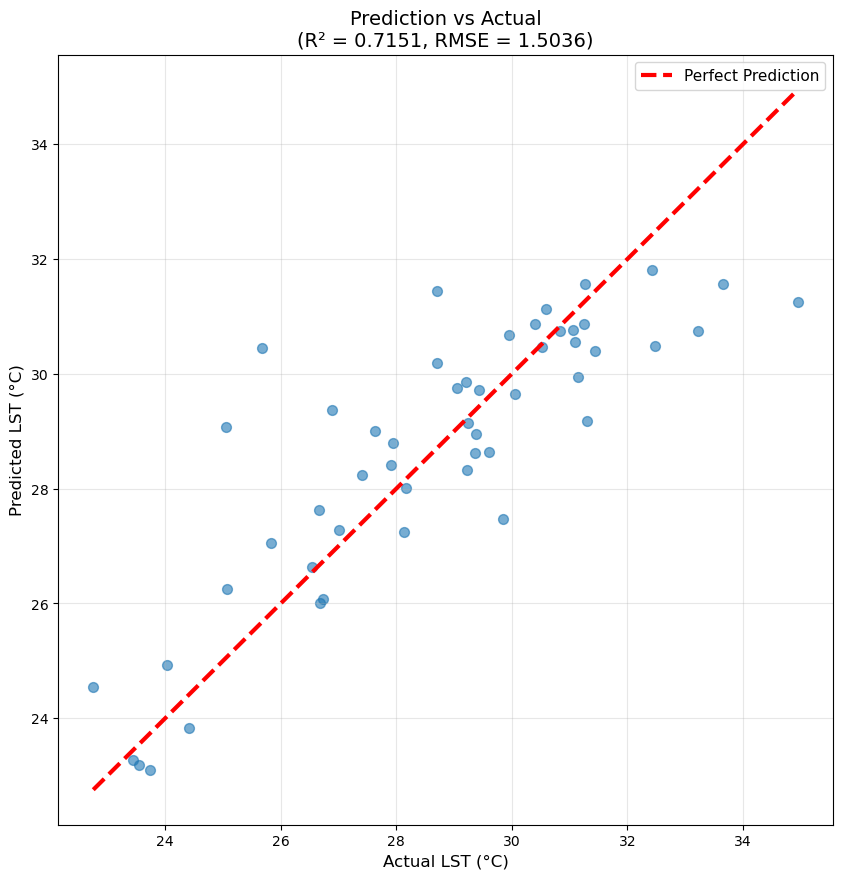

In [54]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, best_model['predictions'], alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect Prediction')
plt.xlabel('Actual LST (°C)', fontsize=12)
plt.ylabel('Predicted LST (°C)', fontsize=12)
plt.title(f'Prediction vs Actual\n(R² = {best_model["r2"]:.4f}, RMSE = {best_model["rmse"]:.4f})', 
          fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.savefig("prediction_Vs_actual.png", dpi=300, bbox_inches="tight")

In [55]:
#Residuals

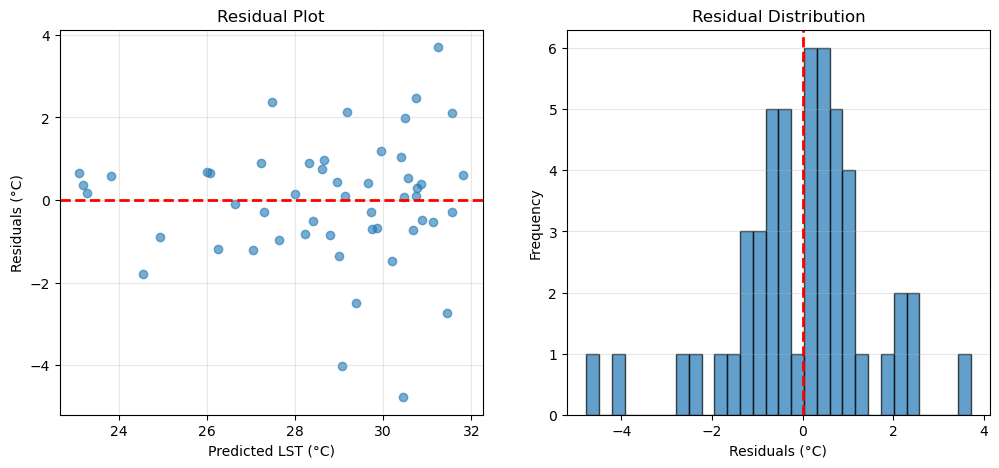

In [56]:
residuals = y_test - best_model['predictions']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(best_model['predictions'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted LST (°C)')
plt.ylabel('Residuals (°C)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (°C)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3, axis='y')
plt.savefig("residual.png", dpi=300, bbox_inches="tight")